## Insurance Prediction Model
Machine Learning Project - 2024

Import Libraries

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

Load and display train dataset

In [2]:
df_insurance = pd.read_csv("./train_Insurance.csv")
df_insurance.drop(axis=1, labels=['Customer Id'], inplace=True)
df_insurance

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,2012,1.0,1,N,V,V,U,1240.0,Wood-framed,without,75117,non
1,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,62916,non
2,2013,1.0,1,V,N,O,R,4984.0,Non-combustible,4,31149,oui
3,2016,0.5,0,N,V,V,U,600.0,Wood-framed,without,6012,oui
4,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,57631,non
...,...,...,...,...,...,...,...,...,...,...,...,...
5007,2013,1.0,0,N,V,V,U,550.0,Ordinary,without,33063,oui
5008,2012,0.5,0,V,N,O,R,1000.0,Fire-resistive,4,13004,non
5009,2015,1.0,1,V,N,O,R,480.0,Ordinary,3,94059,non
5010,2012,0.5,0,V,N,O,R,536.0,Fire-resistive,4,74243,non


**Phase 1: Analyse Data**

In [3]:
df_insurance.dtypes
df_insurance.info()
df_insurance.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   5012 non-null   int64  
 1   Insured_Period      5012 non-null   float64
 2   Residential         5012 non-null   int64  
 3   Building_Painted    5012 non-null   object 
 4   Building_Fenced     5012 non-null   object 
 5   Garden              5008 non-null   object 
 6   Settlement          5012 non-null   object 
 7   Building Dimension  4935 non-null   float64
 8   Building_Type       5012 non-null   object 
 9   NumberOfWindows     5012 non-null   object 
 10  Geo_Code            4939 non-null   object 
 11  Claim               5012 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 470.0+ KB


YearOfObservation      0
Insured_Period         0
Residential            0
Building_Painted       0
Building_Fenced        0
Garden                 4
Settlement             0
Building Dimension    77
Building_Type          0
NumberOfWindows        0
Geo_Code              73
Claim                  0
dtype: int64

In [4]:
def get_numeric_attributes(df:pd.DataFrame) ->list:
  return list(df_insurance.select_dtypes(include='number'))

def get_discrete_attributes(df:pd.DataFrame)->list:
  return list(df_insurance.select_dtypes(include='object'))

get_numeric_attributes(df_insurance)

['YearOfObservation', 'Insured_Period', 'Residential', 'Building Dimension']

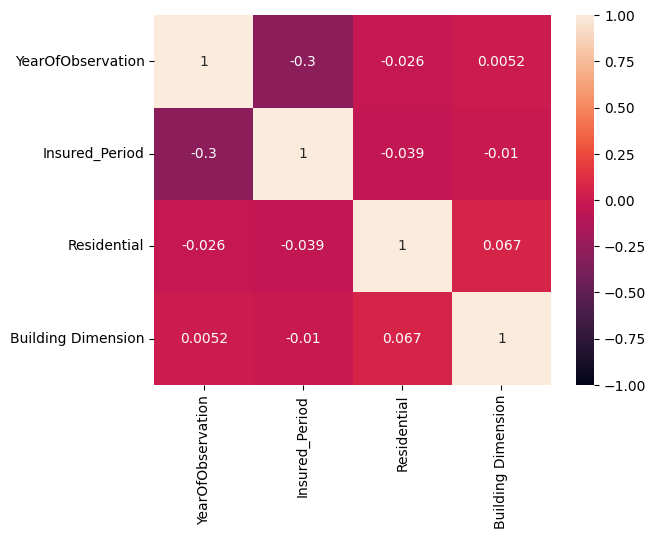

In [5]:
def display_corr_matrix(df):  
  df_corr = df.corr(numeric_only=True)
  sns.heatmap(df_corr, annot=True, vmax=1, vmin=-1)
display_corr_matrix(df_insurance)


We can notice that the **YearOfObservation** attribute is highly correlated with the **Insured_Period** attribute. So his can be used in PCA later

Dealing with Nan Values

1. Garden - Most Frequent

In [6]:
def handle_nan_values(df:pd.DataFrame, column:str, strategy:str):
  mf_imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
  garden_arr = mf_imputer.fit_transform(df_insurance.loc[:, [column]])
  df_insurance[column] = pd.DataFrame(data=garden_arr, columns=[column])
  
handle_nan_values(df_insurance, 'Garden', 'most_frequent')
df_insurance.isnull().sum()

YearOfObservation      0
Insured_Period         0
Residential            0
Building_Painted       0
Building_Fenced        0
Garden                 0
Settlement             0
Building Dimension    77
Building_Type          0
NumberOfWindows        0
Geo_Code              73
Claim                  0
dtype: int64

2. Building Dimension - Nan Values

YearOfObservation      0
Insured_Period         0
Residential            0
Building_Painted       0
Building_Fenced        0
Garden                 0
Settlement             0
Building Dimension     0
Building_Type          0
NumberOfWindows        0
Geo_Code              73
Claim                  0
dtype: int64

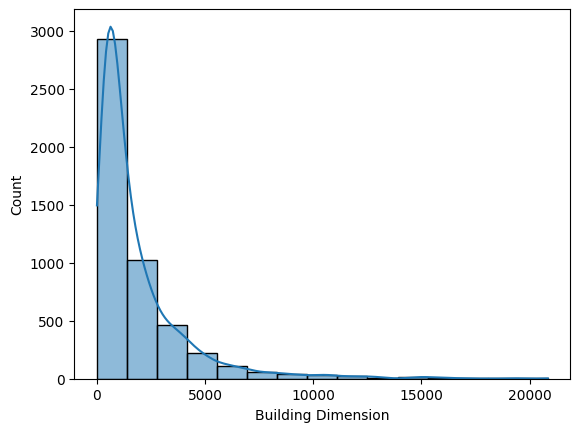

In [7]:
sns.histplot(x='Building Dimension', data=df_insurance, bins=15, kde=True)
# we'll change it with the median
handle_nan_values(df_insurance, 'Building Dimension', 'median')
df_insurance.isnull().sum()

Building Dimension - Transformation/Normalization first
This feature contains a lots of outliers, so we'll use robust scaller

In [8]:
def normalize_with_robust_scaler(df:pd.DataFrame, column:str):
  standard_sclaer = RobustScaler()
  bd_norm_arr = standard_sclaer.fit_transform(df.loc[:, [column]])
  df[column] = bd_norm_arr

normalize_with_robust_scaler(df_insurance, 'Building Dimension')


2. Building Dimension - Outliers

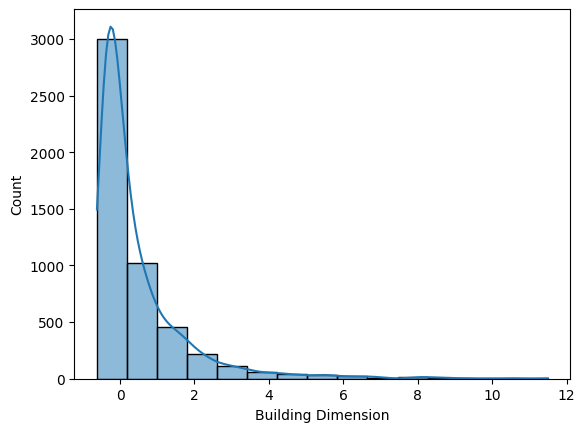

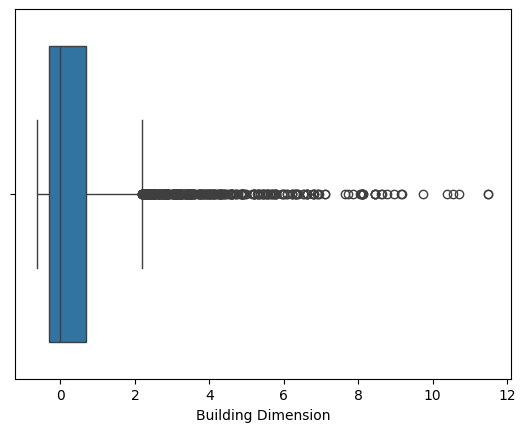

In [9]:
sns.histplot(x='Building Dimension', data=df_insurance, bins=15, kde=True)
plt.show()
sns.boxplot(data=df_insurance, x='Building Dimension')
def handle_outliers_with_box_plot(df:pd.DataFrame, column:str):
  Q1, Q3 = np.percentile(df[column], [25, 75])
  IQR = Q3 - Q1
  upper_limit = Q3+1.5*IQR
  lower_limit = Q1-1.5*IQR
  df[column] = np.where(df[column] > upper_limit, upper_limit,
                                                np.where(df[column] < lower_limit, lower_limit, df[column]))
handle_outliers_with_box_plot(df_insurance, 'Building Dimension')

<Axes: xlabel='Building Dimension'>

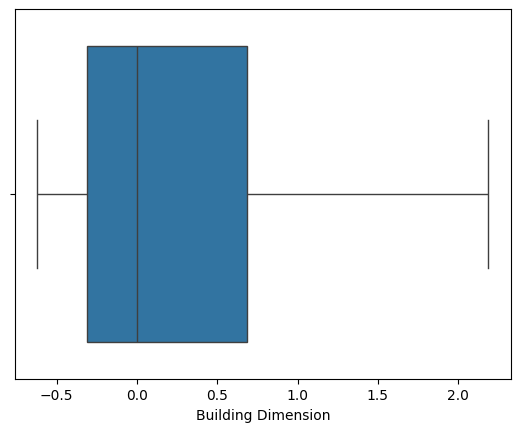

In [10]:
sns.boxplot(data=df_insurance, x='Building Dimension')

3. Geo_Code - Nan values - Most Frequent

In [11]:
#df_insurance['Geo_Code']
handle_nan_values(df_insurance, 'Geo_Code', 'most_frequent')
df_insurance.isnull().sum()

YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
NumberOfWindows       0
Geo_Code              0
Claim                 0
dtype: int64

3. Geo_Code Remove column

In [12]:
def remove_column(df:pd.DataFrame, column:str):
  df.drop(axis=1, labels=[column], inplace=True)

remove_column(df_insurance, 'Geo_Code')
df_insurance

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim
0,2012,1.0,1,N,V,V,U,0.100581,Wood-framed,without,non
1,2012,1.0,0,N,V,V,U,-0.097093,Non-combustible,without,non
2,2013,1.0,1,V,N,O,R,2.187791,Non-combustible,4,oui
3,2016,0.5,0,N,V,V,U,-0.271512,Wood-framed,without,oui
4,2012,1.0,0,N,V,V,U,-0.097093,Non-combustible,without,non
...,...,...,...,...,...,...,...,...,...,...,...
5007,2013,1.0,0,N,V,V,U,-0.300581,Ordinary,without,oui
5008,2012,0.5,0,V,N,O,R,-0.038953,Fire-resistive,4,non
5009,2015,1.0,1,V,N,O,R,-0.341279,Ordinary,3,non
5010,2012,0.5,0,V,N,O,R,-0.308721,Fire-resistive,4,non


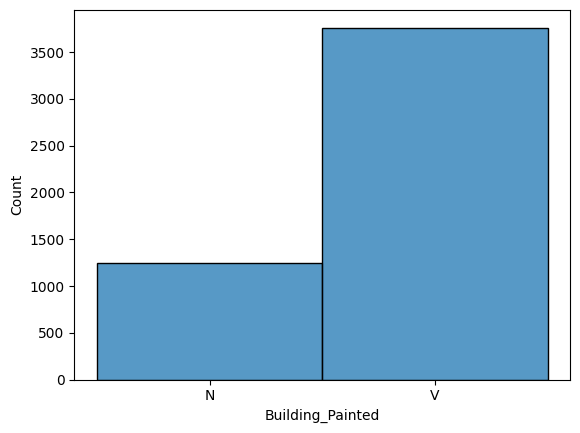

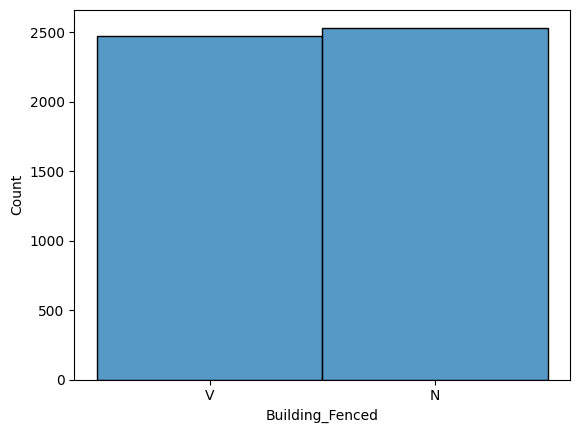

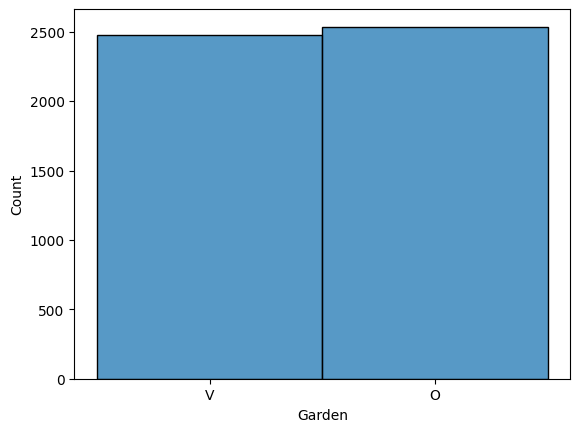

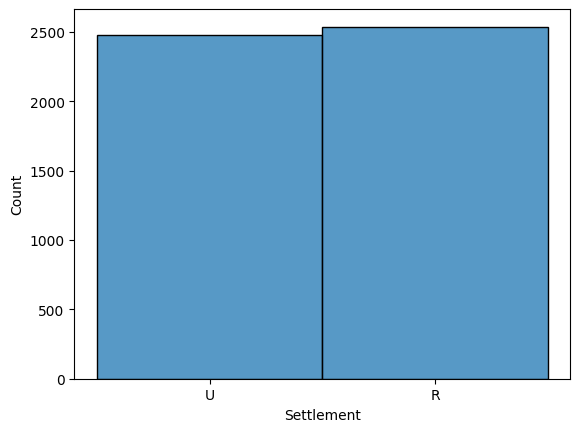

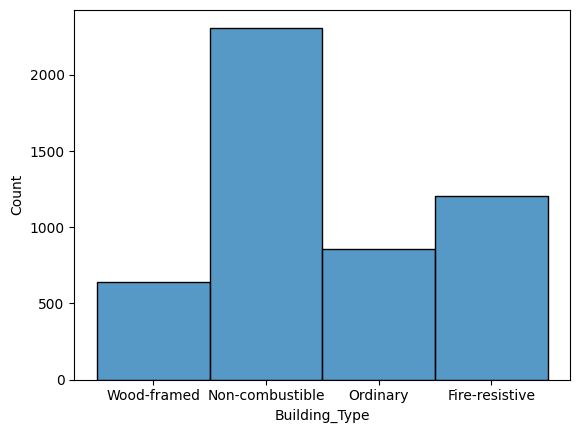

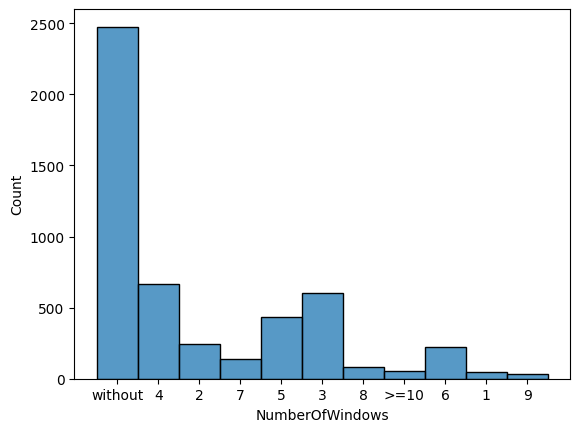

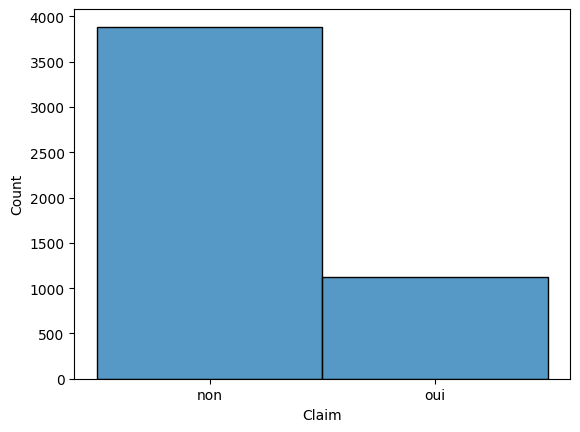

In [13]:
df_insurance.isnull().sum()
discrete_attirbutes = get_discrete_attributes(df_insurance)
for attribute in discrete_attirbutes:
  sns.histplot(data=df_insurance, x=attribute)
  plt.show()

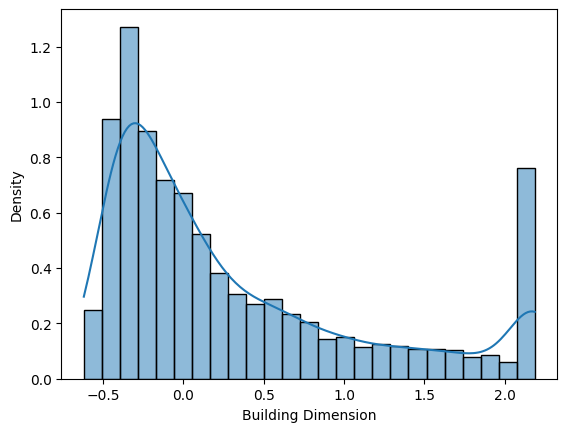

In [14]:
# Displaying the Distribution 
def display_kde_distribution(attribute, df):
  sns.histplot(x=attribute, data=df, kde=True, stat='density')

display_kde_distribution("Building Dimension", df_insurance)

In [15]:
df_insurance.dtypes

YearOfObservation       int64
Insured_Period        float64
Residential             int64
Building_Painted       object
Building_Fenced        object
Garden                 object
Settlement             object
Building Dimension    float64
Building_Type          object
NumberOfWindows        object
Claim                  object
dtype: object

Dealing with outliers

1. YearOfObservation

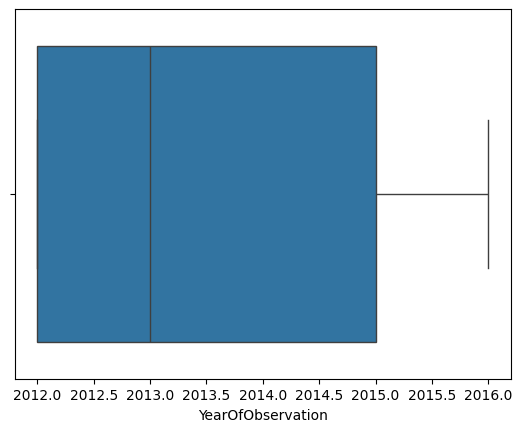

<Axes: xlabel='YearOfObservation', ylabel='Count'>

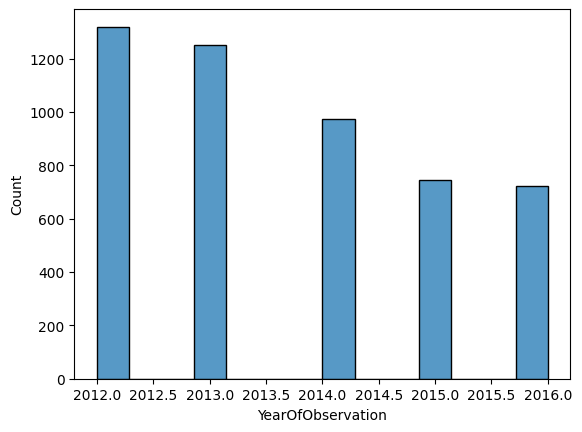

In [16]:
sns.boxplot(data=df_insurance, x='YearOfObservation')
plt.show()
sns.histplot(data=df_insurance, x='YearOfObservation')

2. Insured_Period

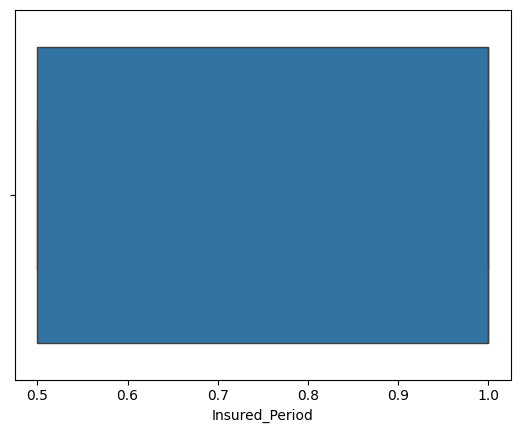

<Axes: xlabel='Insured_Period', ylabel='Count'>

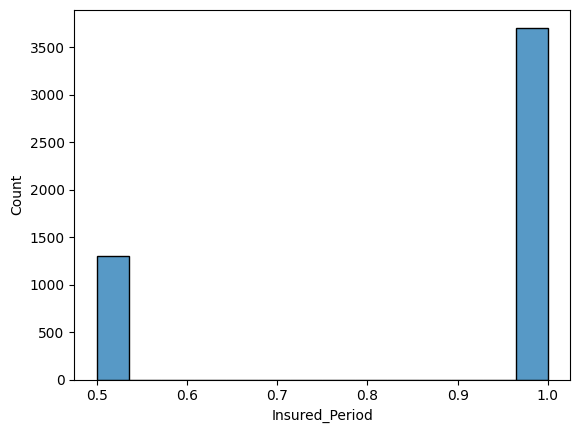

In [17]:
sns.boxplot(data=df_insurance, x='Insured_Period')
plt.show()
sns.histplot(data=df_insurance, x='Insured_Period')

In [18]:
df_insurance['Residential'].unique()

array([1, 0])

Number of windows transformation: 'without' --> 0, '>=10' --> 10

In [19]:
def transform_num_windows(df:pd.DataFrame)->None:
  df['NumberOfWindows'] = np.where(df['NumberOfWindows'] == 'without', '0', np.where(df['NumberOfWindows'] == '>=10', '10', df['NumberOfWindows']))
  ## casting to int
  df['NumberOfWindows'] = pd.to_numeric(df['NumberOfWindows'])

transform_num_windows(df_insurance)
df_insurance

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim
0,2012,1.0,1,N,V,V,U,0.100581,Wood-framed,0,non
1,2012,1.0,0,N,V,V,U,-0.097093,Non-combustible,0,non
2,2013,1.0,1,V,N,O,R,2.187791,Non-combustible,4,oui
3,2016,0.5,0,N,V,V,U,-0.271512,Wood-framed,0,oui
4,2012,1.0,0,N,V,V,U,-0.097093,Non-combustible,0,non
...,...,...,...,...,...,...,...,...,...,...,...
5007,2013,1.0,0,N,V,V,U,-0.300581,Ordinary,0,oui
5008,2012,0.5,0,V,N,O,R,-0.038953,Fire-resistive,4,non
5009,2015,1.0,1,V,N,O,R,-0.341279,Ordinary,3,non
5010,2012,0.5,0,V,N,O,R,-0.308721,Fire-resistive,4,non


Change the 'insured_period' from 0.5 to 0 and cast to int

In [20]:
def transform_insured_period(df:pd.DataFrame):
  df['Insured_Period'] = df['Insured_Period'].apply(lambda x: 0 if x == 0.5 else x)

transform_insured_period(df_insurance)
df_insurance['Insured_Period'].unique()

array([1., 0.])

Encoding non numerical feautres (some ordinal: Building type, and some one hot)

In [21]:
df_insurance

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim
0,2012,1.0,1,N,V,V,U,0.100581,Wood-framed,0,non
1,2012,1.0,0,N,V,V,U,-0.097093,Non-combustible,0,non
2,2013,1.0,1,V,N,O,R,2.187791,Non-combustible,4,oui
3,2016,0.0,0,N,V,V,U,-0.271512,Wood-framed,0,oui
4,2012,1.0,0,N,V,V,U,-0.097093,Non-combustible,0,non
...,...,...,...,...,...,...,...,...,...,...,...
5007,2013,1.0,0,N,V,V,U,-0.300581,Ordinary,0,oui
5008,2012,0.0,0,V,N,O,R,-0.038953,Fire-resistive,4,non
5009,2015,1.0,1,V,N,O,R,-0.341279,Ordinary,3,non
5010,2012,0.0,0,V,N,O,R,-0.308721,Fire-resistive,4,non


encoding Building_Fenced - one hot encoder

In [22]:
def encode_true_false(df:pd.DataFrame, feature:str,categories:list, result_cols:list):
  # this encoder will transform N to 0 and V to 1 in the given feature
  # save the result into new columns of which the names are given in result_cols
  enc = OneHotEncoder(sparse_output=False, categories=[categories])
  df[result_cols] = enc.fit_transform(df.loc[:, [feature]]) # will be added at the end
  df.drop(axis=1, labels=[feature], inplace=True)

encode_true_false(df_insurance, 'Building_Fenced',['V', 'N'], ['Fenced=T', 'Fenced=F'])
df_insurance

,YearOfObservation,Insured_Period,Residential,Building_Painted,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim,Fenced=T,Fenced=F
0,2012,1.0,1,N,V,U,0.100581,Wood-framed,0,non,1.0,0.0
1,2012,1.0,0,N,V,U,-0.097093,Non-combustible,0,non,1.0,0.0
2,2013,1.0,1,V,O,R,2.187791,Non-combustible,4,oui,0.0,1.0
3,2016,0.0,0,N,V,U,-0.271512,Wood-framed,0,oui,1.0,0.0
4,2012,1.0,0,N,V,U,-0.097093,Non-combustible,0,non,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5007,2013,1.0,0,N,V,U,-0.300581,Ordinary,0,oui,1.0,0.0
5008,2012,0.0,0,V,O,R,-0.038953,Fire-resistive,4,non,0.0,1.0
5009,2015,1.0,1,V,O,R,-0.341279,Ordinary,3,non,0.0,1.0
5010,2012,0.0,0,V,O,R,-0.308721,Fire-resistive,4,non,0.0,1.0


Encoding Building_Painted - one hot encoder

In [23]:
encode_true_false(df_insurance, 'Building_Painted',['V', 'N'], ['Painted=T', 'Painted=F'])
df_insurance

,YearOfObservation,Insured_Period,Residential,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim,Fenced=T,Fenced=F,Painted=T,Painted=F
0,2012,1.0,1,V,U,0.100581,Wood-framed,0,non,1.0,0.0,0.0,1.0
1,2012,1.0,0,V,U,-0.097093,Non-combustible,0,non,1.0,0.0,0.0,1.0
2,2013,1.0,1,O,R,2.187791,Non-combustible,4,oui,0.0,1.0,1.0,0.0
3,2016,0.0,0,V,U,-0.271512,Wood-framed,0,oui,1.0,0.0,0.0,1.0
4,2012,1.0,0,V,U,-0.097093,Non-combustible,0,non,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,2013,1.0,0,V,U,-0.300581,Ordinary,0,oui,1.0,0.0,0.0,1.0
5008,2012,0.0,0,O,R,-0.038953,Fire-resistive,4,non,0.0,1.0,1.0,0.0
5009,2015,1.0,1,O,R,-0.341279,Ordinary,3,non,0.0,1.0,1.0,0.0
5010,2012,0.0,0,O,R,-0.308721,Fire-resistive,4,non,0.0,1.0,1.0,0.0


Consider Discretisation of num windows (Depending on a strong argument and interpertation)

Remove the YearOfObservation feature, because all new observations after depolyment will be different (new years)

In [24]:
df_insurance.drop(axis=1, labels=['YearOfObservation'], inplace=True)
df_insurance

,Insured_Period,Residential,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim,Fenced=T,Fenced=F,Painted=T,Painted=F
0,1.0,1,V,U,0.100581,Wood-framed,0,non,1.0,0.0,0.0,1.0
1,1.0,0,V,U,-0.097093,Non-combustible,0,non,1.0,0.0,0.0,1.0
2,1.0,1,O,R,2.187791,Non-combustible,4,oui,0.0,1.0,1.0,0.0
3,0.0,0,V,U,-0.271512,Wood-framed,0,oui,1.0,0.0,0.0,1.0
4,1.0,0,V,U,-0.097093,Non-combustible,0,non,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5007,1.0,0,V,U,-0.300581,Ordinary,0,oui,1.0,0.0,0.0,1.0
5008,0.0,0,O,R,-0.038953,Fire-resistive,4,non,0.0,1.0,1.0,0.0
5009,1.0,1,O,R,-0.341279,Ordinary,3,non,0.0,1.0,1.0,0.0
5010,0.0,0,O,R,-0.308721,Fire-resistive,4,non,0.0,1.0,1.0,0.0


Encode Building_Type - using ordinal encoder, because there's a degradation of types (it's like: weak(Wood-framed):0, average(Ordinary):1, strong:2, very strong:3)

In [25]:
def encode_Building_type(df):
  enc = OrdinalEncoder(categories=[['Wood-framed', 'Ordinary', 'Non-combustible', 'Fire-resistive']])
  df['Building_Type'] = enc.fit_transform(df.loc[:, ['Building_Type']])

encode_Building_type(df_insurance)
df_insurance

,Insured_Period,Residential,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim,Fenced=T,Fenced=F,Painted=T,Painted=F
0,1.0,1,V,U,0.100581,0.0,0,non,1.0,0.0,0.0,1.0
1,1.0,0,V,U,-0.097093,2.0,0,non,1.0,0.0,0.0,1.0
2,1.0,1,O,R,2.187791,2.0,4,oui,0.0,1.0,1.0,0.0
3,0.0,0,V,U,-0.271512,0.0,0,oui,1.0,0.0,0.0,1.0
4,1.0,0,V,U,-0.097093,2.0,0,non,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5007,1.0,0,V,U,-0.300581,1.0,0,oui,1.0,0.0,0.0,1.0
5008,0.0,0,O,R,-0.038953,3.0,4,non,0.0,1.0,1.0,0.0
5009,1.0,1,O,R,-0.341279,1.0,3,non,0.0,1.0,1.0,0.0
5010,0.0,0,O,R,-0.308721,3.0,4,non,0.0,1.0,1.0,0.0


Encode Garden

In [26]:
encode_true_false(df_insurance, 'Garden', ['V','O'], ['Garden=T', 'Garden=F'])
df_insurance

,Insured_Period,Residential,Settlement,Building Dimension,Building_Type,NumberOfWindows,Claim,Fenced=T,Fenced=F,Painted=T,Painted=F,Garden=T,Garden=F
0,1.0,1,U,0.100581,0.0,0,non,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0,U,-0.097093,2.0,0,non,1.0,0.0,0.0,1.0,1.0,0.0
2,1.0,1,R,2.187791,2.0,4,oui,0.0,1.0,1.0,0.0,0.0,1.0
3,0.0,0,U,-0.271512,0.0,0,oui,1.0,0.0,0.0,1.0,1.0,0.0
4,1.0,0,U,-0.097093,2.0,0,non,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,1.0,0,U,-0.300581,1.0,0,oui,1.0,0.0,0.0,1.0,1.0,0.0
5008,0.0,0,R,-0.038953,3.0,4,non,0.0,1.0,1.0,0.0,0.0,1.0
5009,1.0,1,R,-0.341279,1.0,3,non,0.0,1.0,1.0,0.0,0.0,1.0
5010,0.0,0,R,-0.308721,3.0,4,non,0.0,1.0,1.0,0.0,0.0,1.0


Encode Settelement

In [27]:
encode_true_false(df_insurance, 'Settlement', ['R', 'U'], ['Settle=R', 'Settle=U'])
df_insurance

,Insured_Period,Residential,Building Dimension,Building_Type,NumberOfWindows,Claim,Fenced=T,Fenced=F,Painted=T,Painted=F,Garden=T,Garden=F,Settle=R,Settle=U
0,1.0,1,0.100581,0.0,0,non,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0,-0.097093,2.0,0,non,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1.0,1,2.187791,2.0,4,oui,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0,-0.271512,0.0,0,oui,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,1.0,0,-0.097093,2.0,0,non,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,1.0,0,-0.300581,1.0,0,oui,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
5008,0.0,0,-0.038953,3.0,4,non,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
5009,1.0,1,-0.341279,1.0,3,non,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
5010,0.0,0,-0.308721,3.0,4,non,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


Seperate data - X and Y

In [28]:
# sepearate data
def seperate_data(df:pd.DataFrame, class_name:str):
  df_cp = df.copy(deep=True)
  Y_train = df_cp.loc[:, [class_name]].values
  df_cp.drop(axis=1, inplace=True, labels=[class_name])
  X_train = df_cp.values
  return X_train, Y_train

X_train, Y_train = seperate_data(df_insurance, 'Claim')
print(type(X_train), X_train.shape)
print(type(Y_train), Y_train.shape)

<class 'numpy.ndarray'> (5012, 13)
<class 'numpy.ndarray'> (5012, 1)


Apply ml algorithms

<Axes: xlabel='Claim', ylabel='Count'>

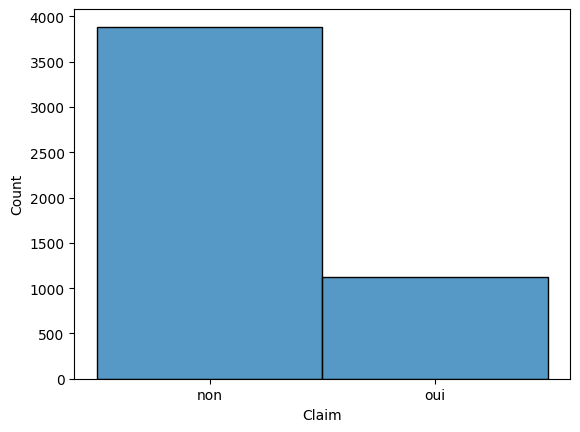

In [29]:
sns.histplot(df_insurance, x='Claim')

1. Decision Tree Classifier

Decision Tree Classifier model accuracy (in %): 92.75738228252195


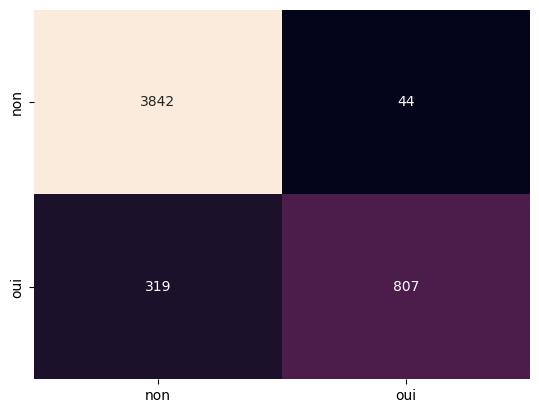

In [30]:
cls = DecisionTreeClassifier()
cls.fit(X_train, Y_train)

Y_p_train = cls.predict(X_train)
c_m_train = confusion_matrix(Y_train, Y_p_train)
sns.heatmap(c_m_train, annot=True, cbar=False, xticklabels=cls.classes_, yticklabels=cls.classes_, fmt='g')
acc = accuracy_score(Y_train, Y_p_train)
print("Decision Tree Classifier model accuracy (in %):", acc*100)

2. Decision tree classifier - testing with test data

In [31]:
from preprocessing import get_test_dataframe

df_test = get_test_dataframe()
X_test, Y_test = seperate_data(df_test, 'Claim')
print(type(X_test), X_test.shape)
print(type(Y_test), Y_test.shape)

<class 'numpy.ndarray'> (2147, 13)
<class 'numpy.ndarray'> (2147, 1)
<class 'numpy.ndarray'> (2147, 13)
<class 'numpy.ndarray'> (2147, 1)


In [32]:
df_test

,Insured_Period,Residential,Building Dimension,Building_Type,NumberOfWindows,Claim,Fenced=T,Fenced=F,Painted=T,Painted=F,Garden=T,Garden=F,Settle=R,Settle=U
0,1.0,0,1.535354,3.0,0,oui,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0,0.203175,3.0,5,non,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1.0,1,0.487157,1.0,6,oui,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0,0.675325,2.0,0,oui,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.0,0,1.082828,3.0,9,non,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,0.0,1,-0.137374,0.0,2,non,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2143,1.0,0,0.000000,2.0,0,non,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2144,1.0,0,-0.213564,2.0,3,non,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2145,1.0,1,-0.307071,2.0,0,oui,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


Decision Tree Classifier model accuracy (in %): 70.37727061015372


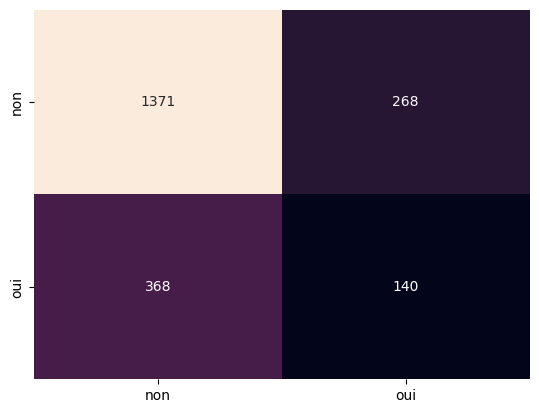

In [33]:
Y_p_test = cls.predict(X_test)
c_m_test = confusion_matrix(Y_test, Y_p_test)
sns.heatmap(c_m_test, annot=True, cbar=False, xticklabels=cls.classes_, yticklabels=cls.classes_, fmt='g')
acc = accuracy_score(Y_test, Y_p_test)
print("Decision Tree Classifier model accuracy (in %):", acc*100)

2. Logistic Regression 

Logistic Regression model accuracy (in %): 78.69114126097367


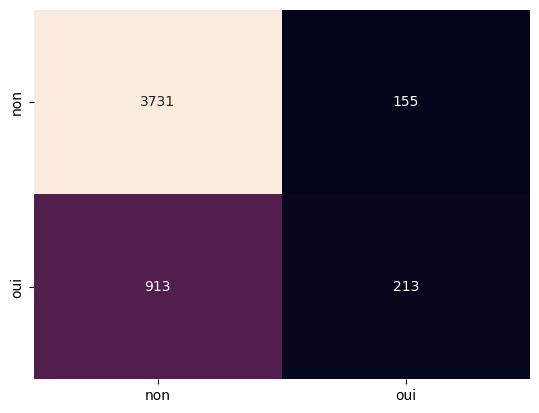

In [34]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, Y_train)
Y_p_train2 = clf.predict(X_train)

c_m_train2 = confusion_matrix(Y_train, Y_p_train2)
sns.heatmap(c_m_train2, annot=True, cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_, fmt='g')
acc = accuracy_score(Y_train, Y_p_train2)
print("Logistic Regression model accuracy (in %):", acc*100)

2. Logistic Regression - test data

In [35]:
from preprocessing import get_test_dataframe

df_test = get_test_dataframe()
X_test, Y_test = seperate_data(df_test, 'Claim')
print(type(X_test), X_test.shape)
print(type(Y_test), Y_test.shape)

<class 'numpy.ndarray'> (2147, 13)
<class 'numpy.ndarray'> (2147, 1)


Logistic Regression model accuracy (in %): 77.17745691662785


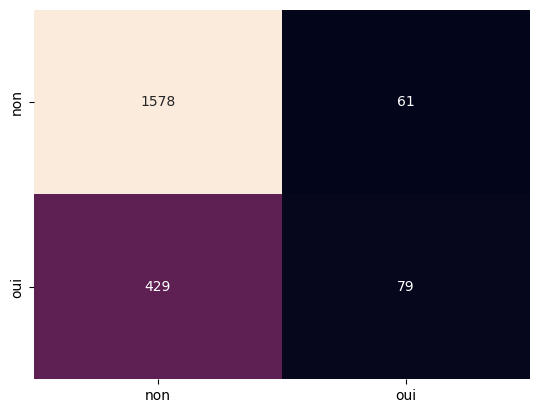

In [36]:
Y_p_test = clf.predict(X_test)
c_m_test = confusion_matrix(Y_test, Y_p_test)
sns.heatmap(c_m_test, annot=True, cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_, fmt='g')
acc = accuracy_score(Y_test, Y_p_test)
print("Logistic Regression model accuracy (in %):", acc*100)

3. RandomForestClassifier

Random Forest Classifier model accuracy (in %): 92.75738228252195


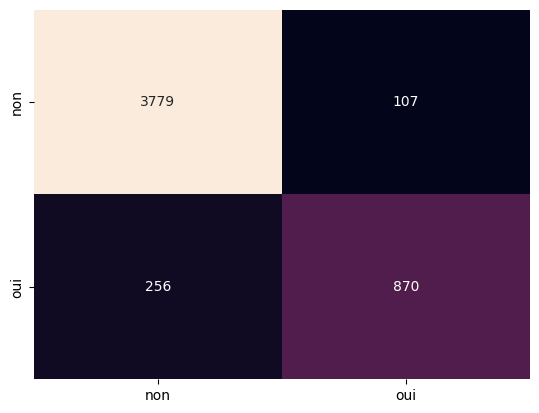

In [37]:
X_train, Y_train = seperate_data(df_insurance, 'Claim')
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, Y_train)
Y_p_train3 = rf_clf.predict(X_train)

c_m_train3 = confusion_matrix(Y_train, Y_p_train3)
sns.heatmap(c_m_train3, annot=True, cbar=False, xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_, fmt='g')
acc = accuracy_score(Y_train, Y_p_train3)
print("Random Forest Classifier model accuracy (in %):", acc*100)

3. Random Forest Classifier - test data

Random Forest Classifier model accuracy (in %): 71.1690731252911


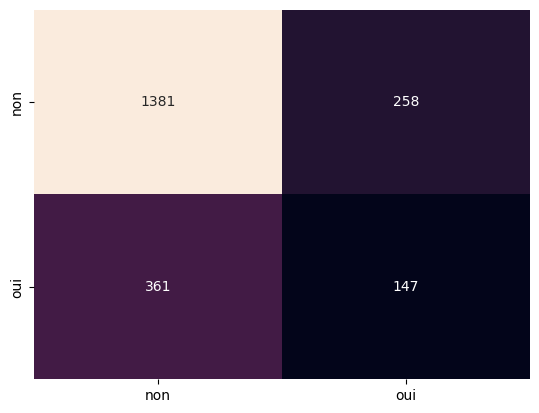

In [38]:
from preprocessing import get_test_dataframe

df_test = get_test_dataframe()
X_test, Y_test = seperate_data(df_test, 'Claim')

Y_p_test = rf_clf.predict(X_test)
c_m_test3 = confusion_matrix(Y_test, Y_p_test)
sns.heatmap(c_m_test3, annot=True, cbar=False, xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_, fmt='g')
acc = accuracy_score(Y_test, Y_p_test)
print("Random Forest Classifier model accuracy (in %):", acc*100)

4. Svm

SVM Classifier model accuracy (in %): 78.63128491620111


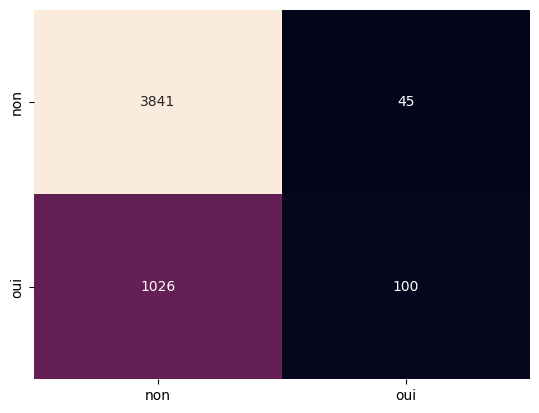

In [45]:
X_train, Y_train = seperate_data(df_insurance, 'Claim')
svm_clf = svm.SVC(kernel='rbf', C = 1.0)
svm_clf.fit(X_train, Y_train)
Y_p_train4 = svm_clf.predict(X_train)

c_m_train3 = confusion_matrix(Y_train, Y_p_train4)
sns.heatmap(c_m_train3, annot=True, cbar=False, xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_, fmt='g')
acc = accuracy_score(Y_train, Y_p_train4)
print("SVM Classifier model accuracy (in %):", acc*100)

4. SVM classifier - test data

SVM Classifier model accuracy (in %): 76.61853749417791


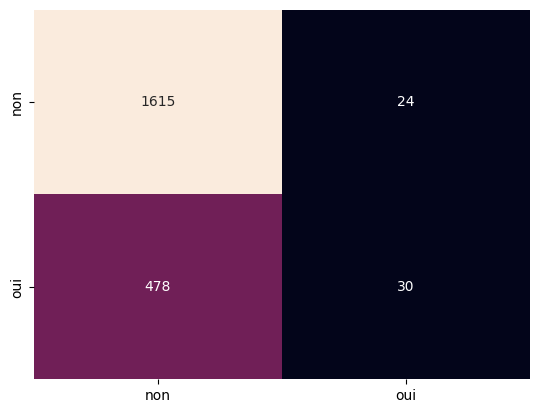

In [43]:
from preprocessing import get_test_dataframe

df_test = get_test_dataframe()
X_test, Y_test = seperate_data(df_test, 'Claim')

Y_p_test = svm_clf.predict(X_test)
c_m_test4 = confusion_matrix(Y_test, Y_p_test)
sns.heatmap(c_m_test4, annot=True, cbar=False, xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_, fmt='g')
acc = accuracy_score(Y_test, Y_p_test)
print("SVM Classifier model accuracy (in %):", acc*100)

5. MLPClassifier

SVM Classifier model accuracy (in %): 79.66879489225857


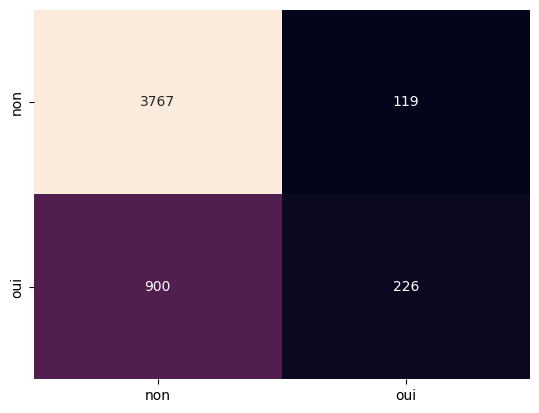

In [47]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, activation='relu', solver='adam', random_state=1)
mlp_clf.fit(X_train, Y_train)
Y_p_train5 = mlp_clf.predict(X_train)

c_m_train4 = confusion_matrix(Y_train, Y_p_train5)


sns.heatmap(c_m_train4, annot=True, cbar=False, xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_, fmt='g')
acc = accuracy_score(Y_train, Y_p_train5)
print("MLPClassifier model accuracy (in %):", acc*100)

5. MLPClassifier - test data

MLPClassifier model accuracy (in %): 77.08430367955287


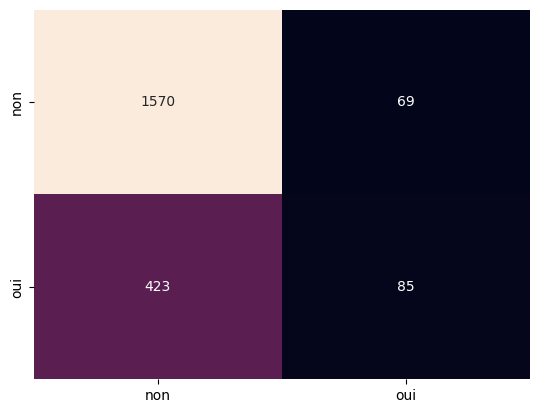

In [48]:
from preprocessing import get_test_dataframe

df_test = get_test_dataframe()
X_test, Y_test = seperate_data(df_test, 'Claim')

Y_p_test = mlp_clf.predict(X_test)
c_m_test4 = confusion_matrix(Y_test, Y_p_test)
sns.heatmap(c_m_test4, annot=True, cbar=False, xticklabels=mlp_clf.classes_, yticklabels=mlp_clf.classes_, fmt='g')
acc = accuracy_score(Y_test, Y_p_test)
print("MLPClassifier model accuracy (in %):", acc*100)